#Importing and Preparing Data

In [38]:
import os
import pandas as pd
import numpy as np
import re
import string
from datetime import datetime
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import metrics, preprocessing, model_selection

import nltk
nltk.download('stopwords')
import spacy

from tensorflow.keras import models, layers, utils 

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [2]:
dataset_link='https://files.grouplens.org/datasets/movielens/ml-latest-small.zip'

In [3]:
!wget -nc https://files.grouplens.org/datasets/movielens/ml-latest-small.zip
!unzip -n ml-latest-small.zip

--2023-04-29 07:09:29--  https://files.grouplens.org/datasets/movielens/ml-latest-small.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 978202 (955K) [application/zip]
Saving to: ‘ml-latest-small.zip’

ml-latest-small.zip 100%[===================>] 955.28K  --.-KB/s    in 0.1s    

2023-04-29 07:09:29 (6.41 MB/s) - ‘ml-latest-small.zip’ saved [978202/978202]

Archive:  ml-latest-small.zip
   creating: ml-latest-small/
  inflating: ml-latest-small/links.csv  
  inflating: ml-latest-small/tags.csv  
  inflating: ml-latest-small/ratings.csv  
  inflating: ml-latest-small/README.txt  
  inflating: ml-latest-small/movies.csv  


## Loading MovieLens dataset

This dataset (ml-latest-small) describes 5-star rating and free-text tagging activity from [MovieLens](http://movielens.org), a movie recommendation service. It contains 100836 ratings and 3683 tag applications across 9742 movies. These data were created by 610 users between March 29, 1996 and September 24, 2018. This dataset was generated on September 26, 2018.

In [4]:
df_movies = pd.read_csv('/content/ml-latest-small/movies.csv')

df_movies = df_movies[~df_movies["genres"].isna()]

# df_movies["name"] = df_movies["title"].apply(lambda x: re.sub("[\(\[].*?[\)\]]", "", x).strip())
# df_movies["date"] = df_movies["title"].apply(lambda x: int(x.split("(")[-1].split("–")[0].replace(")","").strip()) 
#                                                              if "(" in x else np.nan)

## add features
# df_movies["old"] = df_movies["date"].apply(lambda x: 1 if x < 2000 else 0)


df_movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [5]:
tags = [i.split("|") for i in df_movies["genres"].unique()]
columns = list(set([i for lst in tags for i in lst]))
columns.remove('(no genres listed)')
print(columns)

['Action', 'Mystery', 'War', 'Sci-Fi', 'Children', 'Crime', 'Western', 'Documentary', 'Film-Noir', 'Comedy', 'Animation', 'Drama', 'Horror', 'Thriller', 'IMAX', 'Fantasy', 'Romance', 'Adventure', 'Musical']


In [6]:
for col in columns:
    df_movies[col] = df_movies["genres"].apply(lambda x: 1 if col in x else 0)
df_movies.head()

,movieId,title,genres,Action,Mystery,War,Sci-Fi,Children,Crime,Western,...,Comedy,Animation,Drama,Horror,Thriller,IMAX,Fantasy,Romance,Adventure,Musical
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,0,0,0,0,1,0,0,...,1,1,0,0,0,0,1,0,1,0
1,2,Jumanji (1995),Adventure|Children|Fantasy,0,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,1,0
2,3,Grumpier Old Men (1995),Comedy|Romance,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,1,0,0
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,0,0,0,0,0,0,0,...,1,0,1,0,0,0,0,1,0,0
4,5,Father of the Bride Part II (1995),Comedy,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


In [7]:
df_ratings = pd.read_csv('/content/ml-latest-small/ratings.csv')

# df_ratings["timestamp_rating"] = df_ratings["timestamp"].apply(lambda x: datetime.fromtimestamp(x))
# df_ratings["daytime_rating"] = df_ratings["timestamp_rating"].apply(lambda x: 1 if 6<int(x.strftime("%H"))<20 else 0)
# df_ratings["weekend_rating"] = df_ratings["timestamp_rating"].apply(lambda x: 1 if x.weekday() in [5,6] else 0)

df_ratings = df_ratings.merge(df_movies[['movieId', 'title']], how='left')
df_ratings["user"] = df_ratings["userId"].apply(lambda x: x-1)
le = preprocessing.LabelEncoder()
df_ratings["product"] = le.fit_transform(df_ratings["movieId"])
df_ratings.head()

,userId,movieId,rating,timestamp,title,user,product
0,1,1,4.0,964982703,Toy Story (1995),0,0
1,1,3,4.0,964981247,Grumpier Old Men (1995),0,2
2,1,6,4.0,964982224,Heat (1995),0,5
3,1,47,5.0,964983815,Seven (a.k.a. Se7en) (1995),0,43
4,1,50,5.0,964982931,"Usual Suspects, The (1995)",0,46


In [8]:
df_ratings.nunique()

userId         610
movieId       9724
rating          10
timestamp    85043
title         9719
user           610
product       9724
dtype: int64

In [9]:
df_tags = pd.read_csv('/content/ml-latest-small/tags.csv')

# df_tags["timestamp_tag"] = df_tags["timestamp"].apply(lambda x: datetime.fromtimestamp(x))
# df_tags["daytime_tag"] = df_tags["timestamp_tag"].apply(lambda x: 1 if 6<int(x.strftime("%H"))<20 else 0)
# df_tags["weekend_tag"] = df_tags["timestamp_tag"].apply(lambda x: 1 if x.weekday() in [5,6] else 0)
df_tags = df_tags.groupby(by=['movieId'], as_index=False).agg({'tag': ', '.join})

df_tags.head()

,movieId,tag
0,1,"pixar, pixar, fun"
1,2,"fantasy, magic board game, Robin Williams, game"
2,3,"moldy, old"
3,5,"pregnancy, remake"
4,7,remake


In [10]:
df_links = pd.read_csv('/content/ml-latest-small/links.csv')
df_links.head()

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


A dataset is created from the existing merged dataset by grouping the unique user id and movie title combination and the ratings by a user to the same movie in different instances (timestamps) are averaged and stored in the new dataset.

Example of a multiple rating scenario by an user to a specific movie title, but somehow it has a different movie id

In [11]:
df_ratings[(df_ratings['title']=='War of the Worlds (2005)') & (df_ratings['userId']== 68)]

,userId,movieId,rating,timestamp,title,user,product
11241,68,34048,2.0,1158532246,War of the Worlds (2005),67,5915
11451,68,64997,2.5,1230497715,War of the Worlds (2005),67,6915


In [12]:
df_ratings_clean = df_ratings.groupby(by=['userId','title'], as_index=False).agg({"rating":"mean"})

df_ratings_clean

,userId,title,rating
0,1,"13th Warrior, The (1999)",4.0
1,1,20 Dates (1998),4.0
2,1,"Abyss, The (1989)",4.0
3,1,"Adventures of Robin Hood, The (1938)",5.0
4,1,Alice in Wonderland (1951),5.0
...,...,...,...
100827,610,[REC] (2007),4.0
100828,610,[REC]² (2009),3.5
100829,610,[REC]³ 3 Génesis (2012),3.0
100830,610,xXx (2002),2.0


# Exploratory data analysis

*   Plot the counts of each rating
*   Plot rating frequency of each movie

**Plot the counts of each rating**

we first need to get the counts of each rating from ratings data

In [13]:
num_users = len(df_ratings_clean['userId'].value_counts())
num_items = len(df_ratings_clean['title'].value_counts())
print('Unique number of users in the dataset: {}'.format(num_users))
print('Unique number of movies in the dataset: {}'.format(num_items))


Unique number of users in the dataset: 610
Unique number of movies in the dataset: 9719


<Axes: xlabel='rating', ylabel='count'>

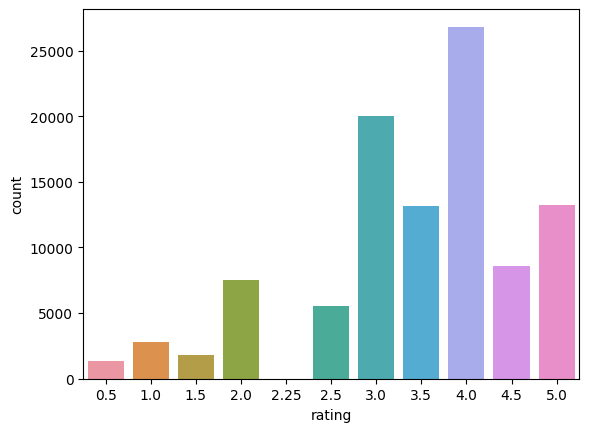

In [14]:
sns.countplot(x='rating', data=df_ratings_clean)

**Plot rating frequency of all movies**

In [15]:
# get rating frequency
movies_count_df = pd.DataFrame(df_ratings_clean.groupby('title').size(), columns=['count'])
movies_count_df.head()

,count
title,
'71 (2014),1
'Hellboy': The Seeds of Creation (2004),1
'Round Midnight (1986),2
'Salem's Lot (2004),1
'Til There Was You (1997),2


Text(0, 0.5, 'number of ratings')

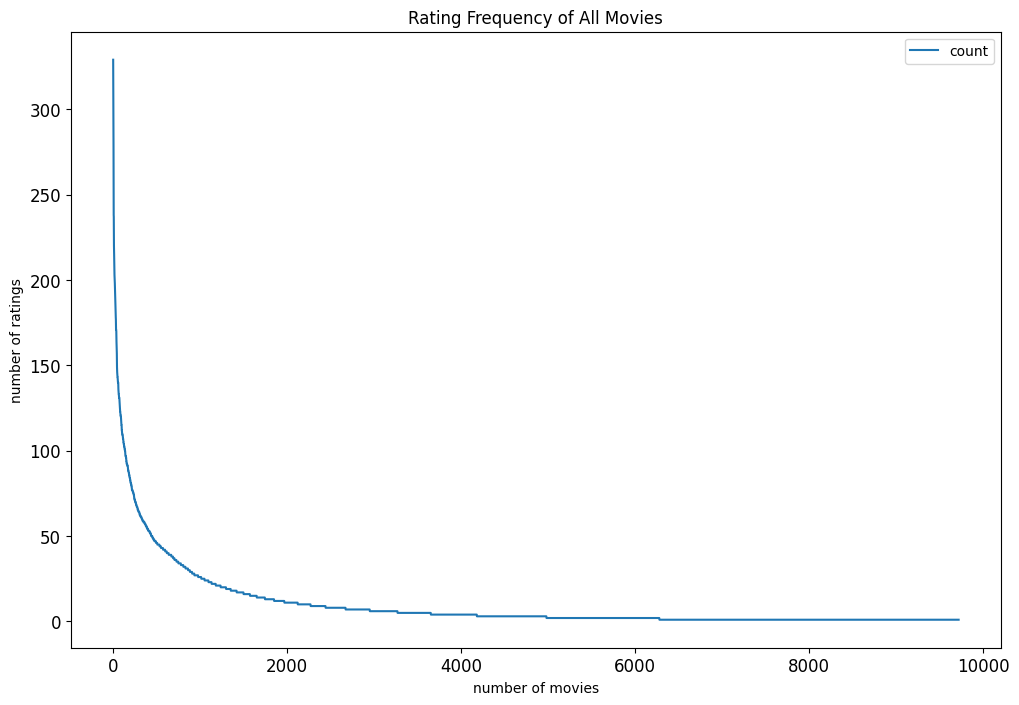

In [16]:
# plot rating frequency of all movies
ax = movies_count_df \
    .sort_values('count', ascending=False) \
    .reset_index(drop=True) \
    .plot(
        figsize=(12, 8),
        title='Rating Frequency of All Movies',
        fontsize=12
    )
ax.set_xlabel("number of movies")
ax.set_ylabel("number of ratings")

**As the size of MovieLens dataset picked for this project is small. There is no need of removing rarely rated movies or users who has given rating for fewer movies.**


*If the dataset is larger, then* (this can be referred when we do similar kind of tasks with a larger dataset, just for future reference)

The distribution of ratings among movies often satisfies a property in real-world settings, which is referred to as the long-tail property. According to this property, only a small fraction of the items are rated frequently. Such items are referred to as popular items. The vast majority of items are rated rarely. This results in a highly skewed distribution of the underlying ratings.

# Non personalized Recommendation

In [17]:
df_ratings_clean.groupby(['title']).agg({"rating":"sum"})['rating'].sort_values(ascending=False)

title
Shawshank Redemption, The (1994)    1404.0
Forrest Gump (1994)                 1370.0
Pulp Fiction (1994)                 1288.5
Matrix, The (1999)                  1165.5
Silence of the Lambs, The (1991)    1161.0
                                     ...  
Uncle Nino (2003)                      0.5
Legionnaire (1998)                     0.5
Ring of Terror (1962)                  0.5
Glitter (2001)                         0.5
Begotten (1990)                        0.5
Name: rating, Length: 9719, dtype: float64

In [18]:
avg_highly_rated_movies = df_ratings_clean.groupby(['title']).agg({"rating":"mean"})['rating'].sort_values(ascending=False)
avg_highly_rated_movies = avg_highly_rated_movies.to_frame()
avg_highly_rated_movies.reset_index(level=0, inplace=True)
avg_highly_rated_movies.columns = ['movie title', 'avg rating']
avg_highly_rated_movies

,movie title,avg rating
0,Gena the Crocodile (1969),5.0
1,True Stories (1986),5.0
2,Cosmic Scrat-tastrophe (2015),5.0
3,Love and Pigeons (1985),5.0
4,Red Sorghum (Hong gao liang) (1987),5.0
...,...,...
9714,Don't Look Now (1973),0.5
9715,Journey 2: The Mysterious Island (2012),0.5
9716,Joe Dirt 2: Beautiful Loser (2015),0.5
9717,Jesus Christ Vampire Hunter (2001),0.5


In [19]:
popular_movies = df_ratings_clean.groupby(['title']).agg({"rating":"count"})['rating'].sort_values(ascending=False)
popular_movies = popular_movies.to_frame()
popular_movies.reset_index(level=0, inplace=True)
popular_movies.columns = ['movie title', 'number of users watching']
popular_movies

,movie title,number of users watching
0,Forrest Gump (1994),329
1,"Shawshank Redemption, The (1994)",317
2,Pulp Fiction (1994),307
3,"Silence of the Lambs, The (1991)",279
4,"Matrix, The (1999)",278
...,...,...
9714,King Solomon's Mines (1950),1
9715,King Solomon's Mines (1937),1
9716,King Ralph (1991),1
9717,King Kong Lives (1986),1


In [21]:
highly_rated_popular_movies = pd.merge(avg_highly_rated_movies, popular_movies, how = 'inner', on='movie title')
highly_rated_popular_movies[(highly_rated_popular_movies['number of users watching']>200) & (highly_rated_popular_movies['avg rating']>=4.0)]

,movie title,avg rating,number of users watching
722,"Shawshank Redemption, The (1994)",4.429022,317
808,Fight Club (1999),4.272936,218
933,"Usual Suspects, The (1995)",4.237745,204
935,Star Wars: Episode IV - A New Hope (1977),4.231076,251
940,Schindler's List (1993),4.225000,220
949,Star Wars: Episode V - The Empire Strikes Back...,4.215640,211
971,Pulp Fiction (1994),4.197068,307
972,"Matrix, The (1999)",4.192446,278
1035,Forrest Gump (1994),4.164134,329
1038,"Silence of the Lambs, The (1991)",4.161290,279


In [22]:
genre_list = columns
genre_list

['Action',
 'Mystery',
 'War',
 'Sci-Fi',
 'Children',
 'Crime',
 'Western',
 'Documentary',
 'Film-Noir',
 'Comedy',
 'Animation',
 'Drama',
 'Horror',
 'Thriller',
 'IMAX',
 'Fantasy',
 'Romance',
 'Adventure',
 'Musical']

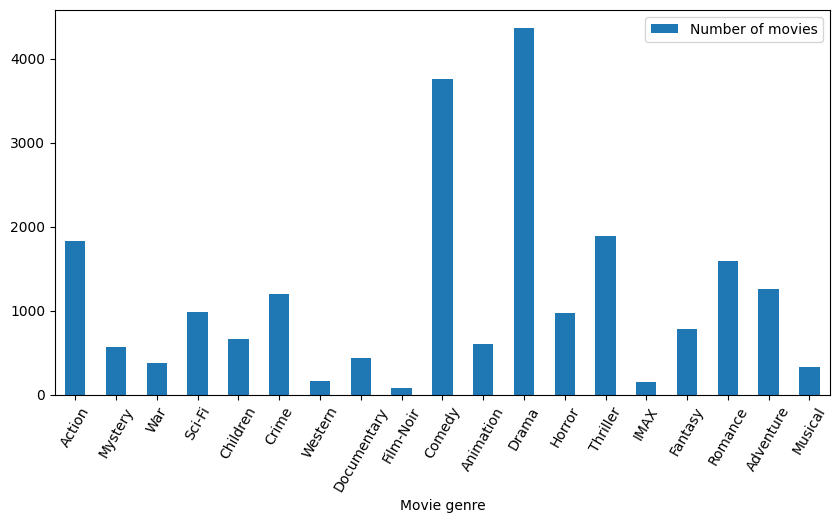

In [23]:
count = []
for i in genre_list:
  # print(i)
  genre_based_movies = df_movies[['movieId','title',i]]
  genre_based_movies = genre_based_movies[genre_based_movies[i] == 1]
  count.append(len(genre_based_movies))
  # merged_genre_movies = pd.merge(dataset, genre_based_movies, how='inner', on='movie id')
  # star_based_visualization(merged_genre_movies)
df_genre_count = pd.DataFrame({'Movie genre':genre_list, 'Number of movies':count})
ax = df_genre_count.plot.bar(x='Movie genre', y='Number of movies', rot=60, figsize=(10, 5))

In [24]:
df_genre_count

,Movie genre,Number of movies
0,Action,1828
1,Mystery,573
2,War,382
3,Sci-Fi,980
4,Children,664
5,Crime,1199
6,Western,167
7,Documentary,440
8,Film-Noir,87
9,Comedy,3756


In [25]:
df_movies

,movieId,title,genres,Action,Mystery,War,Sci-Fi,Children,Crime,Western,...,Comedy,Animation,Drama,Horror,Thriller,IMAX,Fantasy,Romance,Adventure,Musical
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,0,0,0,0,1,0,0,...,1,1,0,0,0,0,1,0,1,0
1,2,Jumanji (1995),Adventure|Children|Fantasy,0,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,1,0
2,3,Grumpier Old Men (1995),Comedy|Romance,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,1,0,0
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,0,0,0,0,0,0,0,...,1,0,1,0,0,0,0,1,0,0
4,5,Father of the Bride Part II (1995),Comedy,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9737,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy,1,0,0,0,0,0,0,...,1,1,0,0,0,0,1,0,0,0
9738,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy,0,0,0,0,0,0,0,...,1,1,0,0,0,0,1,0,0,0
9739,193585,Flint (2017),Drama,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
9740,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation,1,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


In [26]:
def recommendations_genre(genre):
  x = genre
  print("****************************     ****** GENRE: ", x," ******     ******************************")
  print("    ")
  genre_based_movies = df_movies[['title',x]]
  genre_based_movies = genre_based_movies[genre_based_movies[x] == 1]
  merged_genre_movies = pd.merge(df_ratings_clean, genre_based_movies, how='inner', on='title')
  # merged_genre_movies.head()

  high_rated_movies = merged_genre_movies.groupby(['title']).agg({"rating":"mean"})['rating'].sort_values(ascending=False)
  high_rated_movies = high_rated_movies.to_frame()
  high_rated_movies.reset_index(level=0, inplace=True)
  high_rated_movies.columns = ['movie title', 'avg rating']


  popular_movies_ingenre = merged_genre_movies.groupby(['title']).agg({"rating":"count"})['rating'].sort_values(ascending=False)
  popular_movies_ingenre = popular_movies_ingenre.to_frame()
  popular_movies_ingenre.reset_index(level=0, inplace=True)
  popular_movies_ingenre.columns = ['movie title', 'users watching']

  highly_rated_popular_movies = pd.merge(high_rated_movies, popular_movies_ingenre, how = 'inner', on='movie title')
  # highly_rated_popular_movies.head(10)
  viewer_limit = 200
  ratings_limit = 4.0
  count = 0
  check = 0
  while viewer_limit > 0 and ratings_limit > 0:
    s = highly_rated_popular_movies[(highly_rated_popular_movies['users watching']>viewer_limit) & (highly_rated_popular_movies['avg rating']>=ratings_limit)]
    if len(s) < 11:
      if check == 0:
        viewer_limit -= 50
        check = 1
      else:
        ratings_limit -= 0.5
        check = 0
    else:
      break
  print("These movies are the best to suggest to a new user within their requested genre as they are popular and well rated by the users who already watched them.")
  print("These have rating more than ",ratings_limit," with atleast ",viewer_limit ," viewers.")

  print("**Recommendations based popularity and rating. These are top rated popular movies**")
  return s


In [27]:
genre = "Comedy"
recommendations_genre(genre)

****************************     ****** GENRE:  Comedy  ******     ******************************
    
These movies are the best to suggest to a new user within their requested genre as they are popular and well rated by the users who already watched them.
These have rating more than  3.5  with atleast  100  viewers.
**Recommendations based popularity and rating. These are top rated popular movies**


,movie title,avg rating,users watching
359,"Princess Bride, The (1987)",4.232394,142
364,Pulp Fiction (1994),4.197068,307
366,"Amelie (Fabuleux destin d'Amélie Poulain, Le) ...",4.183333,120
379,Forrest Gump (1994),4.164134,329
380,Monty Python and the Holy Grail (1975),4.161765,136
397,Fargo (1996),4.116022,181
432,Trainspotting (1996),4.039216,102
435,Back to the Future (1985),4.038012,171
776,Finding Nemo (2003),3.960993,141
785,Groundhog Day (1993),3.944056,143


# Content Based Recommendation

In [28]:
import numpy as np
from sklearn.metrics import jaccard_score
from scipy.spatial.distance import pdist, squareform

In [29]:
movie_title = 'Apollo 13 (1995)'
user_id = 1

## Genre Based (Jaccard Score)

In [30]:
content_dataset = df_movies.groupby(by='title')[genre_list].max()

In [31]:
content_dataset.head()

,Action,Mystery,War,Sci-Fi,Children,Crime,Western,Documentary,Film-Noir,Comedy,Animation,Drama,Horror,Thriller,IMAX,Fantasy,Romance,Adventure,Musical
title,,,,,,,,,,,,,,,,,,,
'71 (2014),1,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0
'Hellboy': The Seeds of Creation (2004),1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,1,0
'Round Midnight (1986),0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
'Salem's Lot (2004),0,1,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0
'Til There Was You (1997),0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0


In [32]:
starwars_values = content_dataset.loc['Star Wars: Episode IV - A New Hope (1977)'].values
toy_story_values = content_dataset.loc['Toy Story (1995)'].values
print(jaccard_score(starwars_values, toy_story_values))

0.14285714285714285


In [33]:
# Calculate all pairwise distances
jaccard_distances = pdist(content_dataset.values, metric='jaccard')

# Convert the distances to a square matrix
jaccard_similarity_array = 1 - squareform(jaccard_distances)

# Wrap the array in a pandas DataFrame
jaccard_similarity_df = pd.DataFrame(jaccard_similarity_array, index=content_dataset.index, columns=content_dataset.index)

jaccard_similarity_df.head()

title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...,Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
title,,,,,,,,,,,,,,,,,,,,,
'71 (2014),1.000000,0.125,0.200000,0.333333,0.200000,0.0,0.0,0.25,0.166667,0.000000,...,0.40,0.40,0.2,0.2,0.200000,0.400000,0.400000,0.400000,0.000000,0.000000
'Hellboy': The Seeds of Creation (2004),0.125000,1.000,0.000000,0.000000,0.000000,0.0,0.2,0.00,0.142857,0.285714,...,0.00,0.00,0.0,0.0,0.000000,0.142857,0.142857,0.142857,0.166667,0.166667
'Round Midnight (1986),0.200000,0.000,1.000000,0.200000,0.333333,0.0,0.0,0.50,0.250000,0.000000,...,0.25,0.25,0.0,0.0,0.333333,0.000000,0.000000,0.000000,0.000000,0.333333
'Salem's Lot (2004),0.333333,0.000,0.200000,1.000000,0.200000,0.0,0.0,0.25,0.166667,0.000000,...,0.40,0.75,0.5,0.5,0.200000,0.166667,0.166667,0.166667,0.000000,0.000000
'Til There Was You (1997),0.200000,0.000,0.333333,0.200000,1.000000,0.5,0.0,0.50,0.666667,0.000000,...,0.25,0.25,0.0,0.0,0.333333,0.000000,0.000000,0.000000,0.000000,0.000000


In [34]:
jaccard_similarity_df_converted = jaccard_similarity_df*5

jaccard_similarities_series = jaccard_similarity_df_converted.loc[movie_title].sort_values(ascending=False)

jaccard_similarities_series.head(10)

title
Life of Pi (2012)                                   5.000000
Noah (2014)                                         5.000000
Apollo 13 (1995)                                    5.000000
Harry Potter and the Order of the Phoenix (2007)    3.750000
Captain Phillips (2013)                             3.750000
Black Robe (1991)                                   3.333333
1492: Conquest of Paradise (1992)                   3.333333
Hidalgo (2004)                                      3.333333
Edge, The (1997)                                    3.333333
Never Cry Wolf (1983)                               3.333333
Name: Apollo 13 (1995), dtype: float64

## Tags/Description Based (Cosine Similarity)

In [35]:
df_tags_clean = df_tags.merge(df_movies[['movieId','title']], how='left')
# df_tags_clean = df_tags_clean.groupby(by=['title'], as_index=False).agg({'tag': ', '.join})

In [36]:
# Load spacy
nlp = spacy.load('en_core_web_sm')

def clean_string(text, stem="None"):

    final_string = ""

    # Make lower
    text = text.lower()

    # Remove line breaks
    text = re.sub(r'\n', '', text)

    # Remove puncuation
    translator = str.maketrans('', '', string.punctuation)
    text = text.translate(translator)

    # Remove stop words
    text = text.split()
    useless_words = nltk.corpus.stopwords.words("english")
    useless_words = useless_words + ['hi', 'im']

    text_filtered = [word for word in text if not word in useless_words]

    # Remove numbers
    text_filtered = [re.sub(r'\w*\d\w*', '', w) for w in text_filtered]

    final_string = ' '.join(text_filtered)

    return final_string

In [39]:
df_tags_clean['tag'] = df_tags_clean['tag'].apply(lambda x: clean_string(x))

In [40]:
df_tags_clean

,movieId,tag,title
0,1,pixar pixar fun,Toy Story (1995)
1,2,fantasy magic board game robin williams game,Jumanji (1995)
2,3,moldy old,Grumpier Old Men (1995)
3,5,pregnancy remake,Father of the Bride Part II (1995)
4,7,remake,Sabrina (1995)
...,...,...,...
1567,183611,comedy funny rachel mcadams,Game Night (2018)
1568,184471,adventure alicia vikander video game adaptation,Tomb Raider (2018)
1569,187593,josh brolin ryan reynolds sarcasm,Deadpool 2 (2018)
1570,187595,emilia clarke star wars,Solo: A Star Wars Story (2018)


In [41]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Instantiate the vectorizer object to the vectorizer variable
vectorizer = TfidfVectorizer(min_df=2, max_df=0.8)

# Fit and transform the plot column
vectorized_data = vectorizer.fit_transform(df_tags_clean['tag'])

# Create Dataframe from TF-IDFarray
tfidf_df = pd.DataFrame(vectorized_data.toarray(), columns=vectorizer.get_feature_names_out())

# Assign the movie titles to the index and inspect
tfidf_df.index = df_tags_clean['title']
tfidf_df.head()

,aardman,abuse,acting,action,actress,adam,adolescence,adoption,ads,adultery,...,william,williams,willis,witty,wizards,world,writing,york,zombie,zombies
title,,,,,,,,,,,,,,,,,,,,,
Toy Story (1995),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Jumanji (1995),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.330423,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Grumpier Old Men (1995),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Father of the Bride Part II (1995),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Sabrina (1995),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [42]:
# Import cosine_similarity measure
from sklearn.metrics.pairwise import cosine_similarity

# Create the array of cosine similarity values
cosine_similarity_array = cosine_similarity(tfidf_df)

# Wrap the array in a pandas DataFrame
cosine_similarity_df = pd.DataFrame(cosine_similarity_array, index=tfidf_df.index, columns=tfidf_df.index)

# Print the top 5 rows of the DataFrame
cosine_similarity_df.head()

title,Toy Story (1995),Jumanji (1995),Grumpier Old Men (1995),Father of the Bride Part II (1995),Sabrina (1995),"American President, The (1995)",Nixon (1995),Casino (1995),Sense and Sensibility (1995),Get Shorty (1995),...,Blade Runner 2049 (2017),Mother! (2017),Jumanji: Welcome to the Jungle (2017),The Shape of Water (2017),The Greatest Showman (2017),Game Night (2018),Tomb Raider (2018),Deadpool 2 (2018),Solo: A Star Wars Story (2018),Gintama: The Movie (2010)
title,,,,,,,,,,,,,,,,,,,,,
Toy Story (1995),1.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
Jumanji (1995),0.0,1.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.464283,0.0,0.0,0.0
Grumpier Old Men (1995),0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
Father of the Bride Part II (1995),0.0,0.0,0.0,1.000000,0.675448,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
Sabrina (1995),0.0,0.0,0.0,0.675448,1.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0


In [43]:
# Convert the value to 5 star-rating
cosine_similarity_df_converted = cosine_similarity_df*5

# Find the values for the movie 
cosine_similarity_series = cosine_similarity_df_converted.loc[movie_title]

# Sort these values highest to lowest
ordered_similarities = cosine_similarity_series.sort_values(ascending=False)

# Print the results
ordered_similarities.head(10)

title
Apollo 13 (1995)                                         5.000000
SpaceCamp (1986)                                         3.880400
Right Stuff, The (1983)                                  3.880400
Grand Day Out with Wallace and Gromit, A (1989)          3.153172
Babylon 5: In the Beginning (1998)                       2.426342
Armageddon (1998)                                        2.426342
Star Wars: Episode III - Revenge of the Sith (2005)      2.104349
Aliens (1986)                                            2.061916
Forbidden Planet (1956)                                  1.286375
Star Wars: Episode V - The Empire Strikes Back (1980)    1.253573
Name: Apollo 13 (1995), dtype: float64

## Combined Content-Based Recommendation

In [44]:
# Find the average values for the Apollo movie 
mix_content_based_df = jaccard_similarities_series.to_frame('genre_score').join(ordered_similarities.to_frame('tag_score'))
mix_content_based_df['avg_score'] = (mix_content_based_df['genre_score'] + mix_content_based_df['tag_score']) / 2

# Sort these values highest to lowest
ordered_mix = mix_content_based_df.sort_values(by='avg_score', ascending=False)

# Print the results
ordered_mix.head(10)

,genre_score,tag_score,avg_score
title,,,
Apollo 13 (1995),5.000000,5.000000,5.000000
"Right Stuff, The (1983)",1.666667,3.880400,2.773533
SpaceCamp (1986),1.250000,3.880400,2.565200
Life of Pi (2012),5.000000,0.000000,2.500000
"Grand Day Out with Wallace and Gromit, A (1989)",0.714286,3.153172,1.933729
Captain Phillips (2013),3.750000,0.000000,1.875000
Babylon 5: In the Beginning (1998),1.250000,2.426342,1.838171
2001: A Space Odyssey (1968),2.500000,0.876637,1.688318
Rabbit-Proof Fence (2002),3.333333,0.000000,1.666667


# User-Movie Rating Similarities

In [48]:
df_ratings_clean.head()


,userId,title,rating
0,1,"13th Warrior, The (1999)",4.0
1,1,20 Dates (1998),4.0
2,1,"Abyss, The (1989)",4.0
3,1,"Adventures of Robin Hood, The (1938)",5.0
4,1,Alice in Wonderland (1951),5.0


In [49]:
user_ratings_table = df_ratings_clean.pivot(index="userId", columns="title", values="rating")
user_ratings_table.head()

title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...,Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
userId,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [50]:
# Get the average rating for each user 
avg_ratings = user_ratings_table.mean(axis=1)

# Center each users ratings around 0
user_ratings_table_centered = user_ratings_table.sub(avg_ratings, axis=0)

# Fill in the missing data with 0s
user_ratings_centered = user_ratings_table_centered.fillna(0)

user_ratings_centered.head()

title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...,Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
userId,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.366379,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0


In [51]:
movie_ratings_table = user_ratings_table.T

# Get the average rating for each user 
avg_movie_ratings = movie_ratings_table.mean(axis=1)

# Center each users ratings around 0
movie_ratings_centered = movie_ratings_table.sub(avg_movie_ratings, axis=0)

# Fill in the missing data with 0s
movie_ratings_centered = movie_ratings_centered.fillna(0)

movie_ratings_centered.head()

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
title,,,,,,,,,,,,,,,,,,,,,
'71 (2014),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
'Hellboy': The Seeds of Creation (2004),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
'Round Midnight (1986),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
'Salem's Lot (2004),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
'Til There Was You (1997),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [52]:
id_1 = df_movies[df_movies['title']=='Apollo 13 (1995)']['movieId'].values[0]
id_2 = df_movies[df_movies['title']=='SpaceCamp (1986)']['movieId'].values[0]
id_2

4812

In [53]:
from sklearn.metrics.pairwise import cosine_similarity

# Assign the arrays to variables
ts = movie_ratings_centered.loc['Apollo 13 (1995)'].values.reshape(1, -1)
ts2 = movie_ratings_centered.loc['SpaceCamp (1986)'].values.reshape(1, -1)

# Find the similarity between two Star Wars movies
similarity_A = cosine_similarity(ts, ts2)
print(similarity_A)

[[-0.02209098]]


In [54]:
from sklearn.metrics.pairwise import cosine_similarity

# Generate the similarity matrix
similarities = cosine_similarity(movie_ratings_centered)

# Wrap the similarities in a DataFrame
cosine_similarity_df = pd.DataFrame(similarities, index=movie_ratings_centered.index, columns=[movie_ratings_centered.index])

# Find the similarity values for a specific movie
cosine_similarity_series = cosine_similarity_df.loc['Apollo 13 (1995)']

# Sort these values highest to lowest
ordered_similarities = cosine_similarity_series.sort_values(ascending=False)

# ordered_similarities = ordered_similarities.to_frame('rating_similarity').merge(df_movies[['movieId', 'title']], how = 'left', on='movieId')

ordered_similarities.head(10)

title                                      
Apollo 13 (1995)                               1.000000
Outbreak (1995)                                0.274511
Net, The (1995)                                0.263375
Terminator 2: Judgment Day (1991)              0.244152
Batman Forever (1995)                          0.228493
Fugitive, The (1993)                           0.223095
Firm, The (1993)                               0.218332
William Shakespeare's Romeo + Juliet (1996)    0.218067
Killing Fields, The (1984)                     0.216946
While You Were Sleeping (1995)                 0.215781
Name: Apollo 13 (1995), dtype: float64

In [55]:
# Generate the similarity matrix
user_similarities = cosine_similarity(user_ratings_centered)

# Wrap the similarities in a DataFrame
user_similarity_df = pd.DataFrame(user_similarities, index=user_ratings_centered.index, columns=[user_ratings_centered.index])

In [56]:
user_similarity_df

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
userId,,,,,,,,,,,,,,,,,,,,,
1,1.000000,0.001265,0.000553,0.048419,0.021847,-0.045497,-0.006200,0.047013,0.019510,-0.008754,...,0.018127,-0.017172,-0.015221,-0.037059,-0.029121,0.012016,0.055261,0.075224,-0.025713,0.010932
2,0.001265,1.000000,0.000000,-0.017164,0.021796,-0.021051,-0.011114,-0.048085,0.000000,0.003012,...,-0.050551,-0.031581,-0.001688,0.000000,0.000000,0.006226,-0.020504,-0.006001,-0.060091,0.024999
3,0.000553,0.000000,1.000000,-0.011260,-0.031539,0.004800,0.000000,-0.032471,0.000000,0.000000,...,-0.004904,-0.016117,0.017749,0.000000,-0.001431,-0.037289,-0.007789,-0.013001,0.000000,0.019550
4,0.048419,-0.017164,-0.011260,1.000000,-0.029620,0.013956,0.058091,0.002065,-0.005874,0.051590,...,-0.037687,0.063122,0.027640,-0.013782,0.040037,0.020590,0.014628,-0.037569,-0.017884,-0.000995
5,0.021847,0.021796,-0.031539,-0.029620,1.000000,0.009111,0.010117,-0.012284,0.000000,-0.033165,...,0.015964,0.012427,0.027076,0.012461,-0.036272,0.026319,0.031896,-0.001751,0.093829,-0.000278
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,0.012016,0.006226,-0.037289,0.020590,0.026319,-0.009137,0.028326,0.022277,0.031633,-0.039946,...,0.053683,0.016384,0.098011,0.061078,0.019678,1.000000,0.017927,0.056676,0.038422,0.075464
607,0.055261,-0.020504,-0.007789,0.014628,0.031896,0.045501,0.030981,0.048822,-0.012161,-0.017656,...,0.049059,0.038197,0.049317,0.002355,-0.029381,0.017927,1.000000,0.044514,0.019049,0.021860
608,0.075224,-0.006001,-0.013001,-0.037569,-0.001751,0.021727,0.028414,0.071759,0.032783,-0.052000,...,0.069198,0.051388,0.012801,0.006319,-0.007978,0.056676,0.044514,1.000000,0.050714,0.054454


In [57]:
# Isolate the similarity scores for user_1 and sort
user_similarity_series = user_similarity_df.loc[1]
ordered_similarities = user_similarity_series.sort_values(ascending=False)

# Find the top 10 most similar users
ordered_similarities = ordered_similarities.to_frame().reset_index()
nearest_neighbors = ordered_similarities['userId'][1:11].values

# Extract the ratings of the neighbors
neighbor_ratings = user_ratings_centered.loc[nearest_neighbors]


# Calculate the mean rating given by the users nearest neighbors
# movie_title = df_movies[df_movies['title']=='Apollo 13 (1995)']['movieId'].values[0]
print(neighbor_ratings[movie_title].mean())

0.12312770863008766


# Collaborative Filtering

In [58]:
movie_title = 'Apollo 13 (1995)'
user_id = 1

## User-based

In [59]:
# Drop the column you are trying to predict
user_ratings_centered_dropped = user_ratings_centered.drop(movie_title, axis=1)

# Get the data for the user you are predicting for
target_user_x = user_ratings_centered_dropped.loc[user_id]

# Get the target data from user_ratings_table
other_users_y = user_ratings_table[movie_title]

# Get the data for only those that have seen the movie
other_users_x = user_ratings_centered_dropped[other_users_y.notnull()]

# Remove those that have not seen the movie from the target
other_users_y.dropna(inplace=True)

In [60]:
other_users_y

userId
5      3.0
6      4.0
7      4.5
8      4.0
11     5.0
      ... 
602    4.0
605    5.0
607    5.0
608    2.0
609    3.0
Name: Apollo 13 (1995), Length: 201, dtype: float64

In [61]:
target_user_x.head()

title
'71 (2014)                                 0.0
'Hellboy': The Seeds of Creation (2004)    0.0
'Round Midnight (1986)                     0.0
'Salem's Lot (2004)                        0.0
'Til There Was You (1997)                  0.0
Name: 1, dtype: float64

In [62]:
other_users_x.head()

title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...,Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
userId,,,,,,,,,,,,,,,,,,,,,
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [63]:
from sklearn.neighbors import KNeighborsRegressor

# Instantiate the user KNN model
user_knn = KNeighborsRegressor(metric='cosine', n_neighbors=10)

# Fit the model and predict the target user
user_knn.fit(other_users_x, other_users_y)
user_user_pred = user_knn.predict(target_user_x.values.reshape(1,-1))

print(user_user_pred)

[3.8]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KNeighborsRegressor was fitted with feature names
  warnings.warn(


## Item-based

In [64]:
# Drop the column you are trying to predict
movie_ratings_centered_dropped = movie_ratings_centered.drop(user_id, axis=1)

# Get the data for the movie you are predicting for
target_movie_x = movie_ratings_centered_dropped.loc[movie_title]

# Get the target data from movie_ratings_table
other_movies_y = movie_ratings_table[user_id]

# # Get the data for only those that have seen the movie
other_movies_x = movie_ratings_centered_dropped[other_movies_y.notnull()]

# # Remove those that have not seen the movie from the target
other_movies_y.dropna(inplace=True)

In [65]:
# Instantiate the user KNN model
movie_knn = KNeighborsRegressor()

# Fit the model on the movie data and predict
movie_knn.fit(other_movies_x, other_movies_y)
item_item_pred = movie_knn.predict(target_movie_x.values.reshape(1,-1))
print("The item-item model predicts {}".format(item_item_pred))

The item-item model predicts [4.]


# Matrix Factorization using SVD

In [66]:
# Count the occupied cells
sparsity_count = user_ratings_table.isnull().values.sum()

# Count all cells
full_count = user_ratings_table.size

# Find the sparsity of the DataFrame
sparsity = sparsity_count / full_count
print(sparsity)

0.9829922460483859


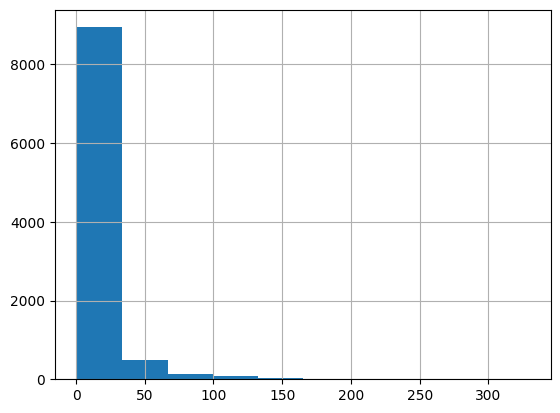

In [67]:
# Count the occupied cells per column
occupied_count = user_ratings_table.notnull().sum()

# Sort the resulting series from low to high
sorted_occupied_count = occupied_count.sort_values()

# Plot a histogram of the values in sorted_occupied_count
sorted_occupied_count.hist()
plt.show()

In [68]:
# Import the required libraries 
from scipy.sparse.linalg import svds
import numpy as np

# Decompose the matrix
U, sigma, Vt = svds(user_ratings_centered.values)

# Convert sigma into a diagonal matrix
sigma = np.diag(sigma)
print(sigma)

[[36.54884233  0.          0.          0.          0.          0.        ]
 [ 0.         37.95486323  0.          0.          0.          0.        ]
 [ 0.          0.         39.37049297  0.          0.          0.        ]
 [ 0.          0.          0.         41.77886272  0.          0.        ]
 [ 0.          0.          0.          0.         43.62209292  0.        ]
 [ 0.          0.          0.          0.          0.         76.20047266]]


In [69]:
# Dot product of U and sigma
U_sigma = np.dot(U, sigma)

# Dot product of result and Vt
U_sigma_Vt = np.dot(U_sigma, Vt)

# Add back on the row means contained in avg_ratings
uncentered_ratings = U_sigma_Vt + avg_ratings.values.reshape(-1, 1)

# Create DataFrame of the results
calc_pred_ratings_df = pd.DataFrame(uncentered_ratings, 
                                    index=user_ratings_centered.index,
                                    columns=user_ratings_centered.columns
                                   )

In [70]:
calc_pred_ratings_df


title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...,Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
userId,,,,,,,,,,,,,,,,,,,,,
1,4.366758,4.366864,4.366117,4.366425,4.365874,4.367775,4.364110,4.365298,4.399567,4.366379,...,4.360731,4.365497,4.367345,4.366390,4.366333,4.387607,4.335274,4.357385,4.346337,4.366739
2,3.948463,3.948253,3.948293,3.948273,3.948342,3.948062,3.949374,3.948554,3.945010,3.948521,...,3.946941,3.949843,3.947476,3.947203,3.948247,3.945910,3.945743,3.946354,3.950818,3.948147
3,2.436697,2.435659,2.435996,2.435841,2.436166,2.435715,2.442690,2.438575,2.420862,2.439383,...,2.437677,2.441960,2.432665,2.431460,2.435774,2.427541,2.436665,2.430367,2.441795,2.435349
4,3.553547,3.556060,3.555342,3.555822,3.555180,3.558750,3.493632,3.545681,3.531246,3.544048,...,3.528199,3.539657,3.563222,3.566525,3.555780,3.588758,3.542657,3.579806,3.533643,3.557405
5,3.636042,3.636611,3.636259,3.636443,3.636168,3.637921,3.632567,3.635113,3.639293,3.635552,...,3.635141,3.632319,3.638571,3.639009,3.636443,3.645666,3.635973,3.638589,3.627942,3.636997
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,3.656747,3.660728,3.655946,3.658587,3.655294,3.677603,3.553893,3.638496,3.686535,3.674837,...,3.665024,3.630286,3.673631,3.673444,3.658190,3.796002,3.655214,3.648094,3.530404,3.662434
607,3.785770,3.786352,3.785971,3.786110,3.785747,3.785805,3.790275,3.784962,3.821457,3.787387,...,3.796064,3.783058,3.788082,3.788376,3.786204,3.794007,3.789866,3.783980,3.777680,3.786174
608,3.144360,3.135605,3.133463,3.134770,3.134419,3.111664,2.848560,3.096719,3.385000,3.245631,...,3.290693,3.227688,3.091068,3.072951,3.134055,3.219383,3.175218,2.972337,3.070776,3.116531


In [71]:
# Sort the ratings of User 5 from high to low
user_1_ratings = calc_pred_ratings_df.loc[1,:].sort_values(ascending=False)

print(user_1_ratings)

title
Pulp Fiction (1994)                                 4.656812
Shawshank Redemption, The (1994)                    4.636315
Schindler's List (1993)                             4.596001
Godfather, The (1972)                               4.591911
Forrest Gump (1994)                                 4.591617
                                                      ...   
Mission: Impossible II (2000)                       4.236465
Wild Wild West (1999)                               4.232032
Independence Day (a.k.a. ID4) (1996)                4.226335
Nutty Professor, The (1996)                         4.220578
Star Wars: Episode I - The Phantom Menace (1999)    4.210075
Name: 1, Length: 9719, dtype: float64


In [72]:
avg_user_ratings_table = pd.DataFrame()
for column in user_ratings_table.columns:
  avg = user_ratings_table[column].mean()
  avg_user_ratings_table[column] = np.array([avg]*user_ratings_table.shape[0])

Streaming output truncated to the last 5000 lines.
<ipython-input-72-774e73b1ea7c>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  avg_user_ratings_table[column] = np.array([avg]*user_ratings_table.shape[0])
<ipython-input-72-774e73b1ea7c>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  avg_user_ratings_table[column] = np.array([avg]*user_ratings_table.shape[0])
<ipython-input-72-774e73b1ea7c>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor

In [73]:
from sklearn.metrics import mean_squared_error

# Extract the ground truth to compare your predictions against
actual_values = user_ratings_table.values
avg_values = avg_user_ratings_table.values
predicted_values = calc_pred_ratings_df.values

# Create a mask of actual_values to only look at the non-missing values in the ground truth
mask = ~np.isnan(actual_values)

# Print the performance of both predictions and compare
print("Mean Squared Error using average prediction =", mean_squared_error(actual_values[mask], avg_values[mask], squared=True))
print("Mean Squared Error using SVD =", mean_squared_error(actual_values[mask], predicted_values[mask], squared=True))

Mean Squared Error using average prediction = 0.7677043808765145
Mean Squared Error using SVD = 0.700155676681152


# Collaborative Filtering using Matrix Factorization and Neural Network

In [74]:
df_ratings.head()

,userId,movieId,rating,timestamp,title,user,product
0,1,1,4.0,964982703,Toy Story (1995),0,0
1,1,3,4.0,964981247,Grumpier Old Men (1995),0,2
2,1,6,4.0,964982224,Heat (1995),0,5
3,1,47,5.0,964983815,Seven (a.k.a. Se7en) (1995),0,43
4,1,50,5.0,964982931,"Usual Suspects, The (1995)",0,46


In [75]:
scaler = preprocessing.MinMaxScaler()
df_ratings["y"] = scaler.fit_transform(df_ratings['rating'].values.reshape(-1, 1))
df_ratings.head()


,userId,movieId,rating,timestamp,title,user,product,y
0,1,1,4.0,964982703,Toy Story (1995),0,0,0.777778
1,1,3,4.0,964981247,Grumpier Old Men (1995),0,2,0.777778
2,1,6,4.0,964982224,Heat (1995),0,5,0.777778
3,1,47,5.0,964983815,Seven (a.k.a. Se7en) (1995),0,43,1.000000
4,1,50,5.0,964982931,"Usual Suspects, The (1995)",0,46,1.000000


In [76]:
dtf_user_ratings = df_ratings.pivot(index="user", columns="product", values="y")
dtf_user_ratings

product,0,1,2,3,4,5,6,7,8,9,...,9714,9715,9716,9717,9718,9719,9720,9721,9722,9723
user,,,,,,,,,,,,,,,,,,,,,
0,0.777778,NaN,0.777778,NaN,NaN,0.777778,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.777778,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
605,0.444444,NaN,NaN,NaN,NaN,NaN,0.444444,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
606,0.777778,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
607,0.444444,0.333333,0.333333,NaN,NaN,NaN,NaN,NaN,NaN,0.777778,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [77]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(df_ratings[["user", "product"]], df_ratings["y"], test_size=0.2, random_state=42)

In [78]:
X_train

,user,product
80568,508,4893
50582,325,7127
8344,56,1575
99603,609,855
71701,461,1808
...,...,...
6265,41,2986
54886,363,116
76820,479,4601
860,5,748


In [79]:
y_train

80568    0.555556
50582    0.777778
8344     0.555556
99603    0.777778
71701    0.333333
           ...   
6265     0.777778
54886    0.777778
76820    0.777778
860      0.555556
15795    1.000000
Name: y, Length: 80668, dtype: float64

In [80]:
embeddings_size = 50
usr, prd = dtf_user_ratings.shape[0], dtf_user_ratings.shape[1]

# Input layer
xusers_in = layers.Input(name="xusers_in", shape=(1,))
xproducts_in = layers.Input(name="xproducts_in", shape=(1,))

# A) Matrix Factorization
## embeddings and reshape
cf_xusers_emb = layers.Embedding(name="cf_xusers_emb", input_dim=usr, output_dim=embeddings_size)(xusers_in)
cf_xusers = layers.Reshape(name='cf_xusers', target_shape=(embeddings_size,))(cf_xusers_emb)
## embeddings and reshape
cf_xproducts_emb = layers.Embedding(name="cf_xproducts_emb", input_dim=prd, output_dim=embeddings_size)(xproducts_in)
cf_xproducts = layers.Reshape(name='cf_xproducts', target_shape=(embeddings_size,))(cf_xproducts_emb)
## product
cf_xx = layers.Dot(name='cf_xx', normalize=True, axes=1)([cf_xusers, cf_xproducts])

# B) Neural Network
## embeddings and reshape
nn_xusers_emb = layers.Embedding(name="nn_xusers_emb", input_dim=usr, output_dim=embeddings_size)(xusers_in)
nn_xusers = layers.Reshape(name='nn_xusers', target_shape=(embeddings_size,))(nn_xusers_emb)
## embeddings and reshape
nn_xproducts_emb = layers.Embedding(name="nn_xproducts_emb", input_dim=prd, output_dim=embeddings_size)(xproducts_in)
nn_xproducts = layers.Reshape(name='nn_xproducts', target_shape=(embeddings_size,))(nn_xproducts_emb)
## concat and dense
nn_xx = layers.Concatenate()([nn_xusers, nn_xproducts])
nn_xx = layers.Dense(name="nn_xx", units=int(embeddings_size/2), activation='relu')(nn_xx)

# Merge A & B
y_out = layers.Concatenate()([cf_xx, nn_xx])
y_out = layers.Dense(name="y_out", units=1, activation='linear')(y_out)

# Compile
model = models.Model(inputs=[xusers_in,xproducts_in], outputs=y_out, name="Neural_CollaborativeFiltering")
model.compile(optimizer='adam', loss='mean_absolute_error', metrics=['mean_absolute_error'])
model.summary()

Model: "Neural_CollaborativeFiltering"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 xusers_in (InputLayer)         [(None, 1)]          0           []                               
                                                                                                  
 xproducts_in (InputLayer)      [(None, 1)]          0           []                               
                                                                                                  
 nn_xusers_emb (Embedding)      (None, 1, 50)        30500       ['xusers_in[0][0]']              
                                                                                                  
 nn_xproducts_emb (Embedding)   (None, 1, 50)        486200      ['xproducts_in[0][0]']           
                                                                      

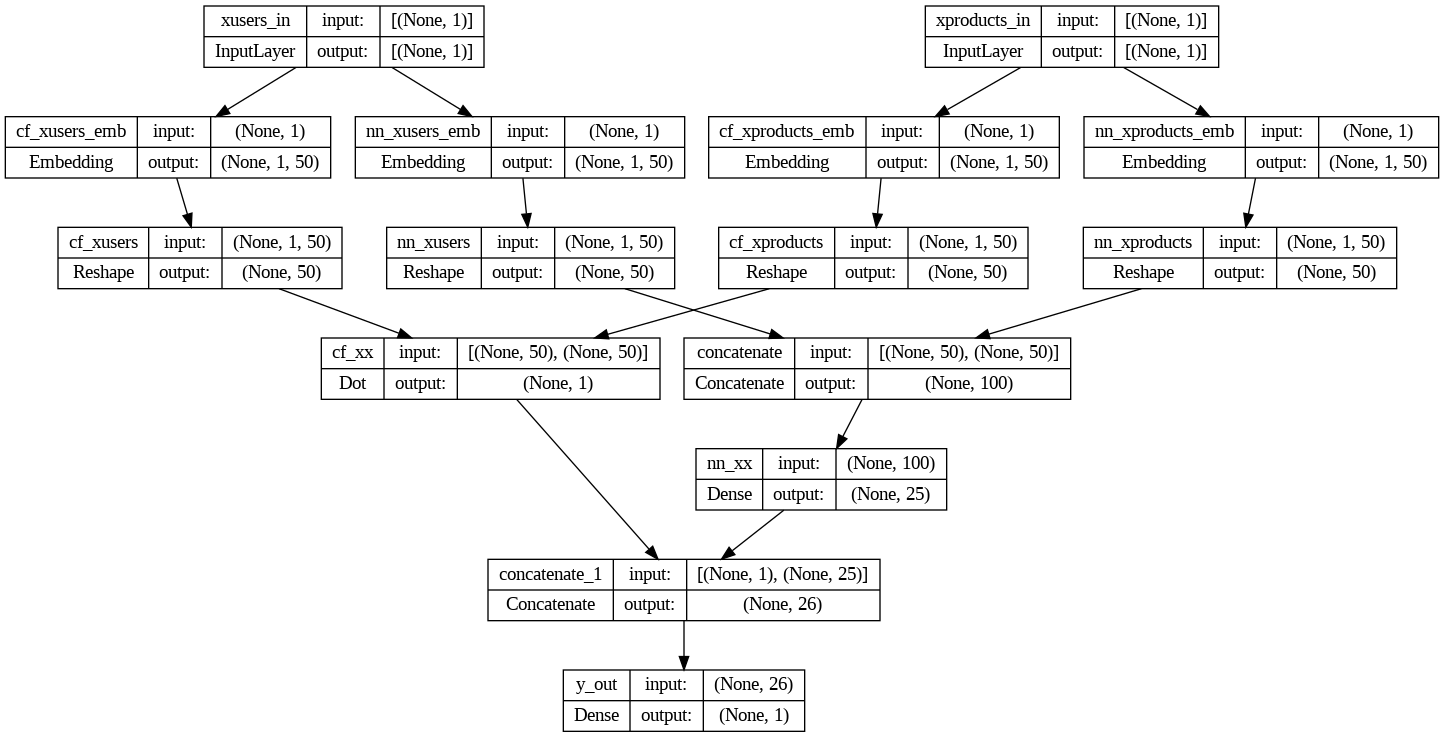

In [81]:
utils.plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

In [82]:
def utils_plot_keras_training(training):
    metrics = [k for k in training.history.keys() if ("loss" not in k) and ("val" not in k)]
    fig, ax = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(15,3))
    
    ## training
    ax[0].set(title="Training")
    ax11 = ax[0].twinx()
    ax[0].plot(training.history['loss'], color='black')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Loss', color='black')
    for metric in metrics:
        ax11.plot(training.history[metric], label=metric)
    ax11.set_ylabel("Score", color='steelblue')
    ax11.legend()
    
    ## validation
    ax[1].set(title="Validation")
    ax22 = ax[1].twinx()
    ax[1].plot(training.history['val_loss'], color='black')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Loss', color='black')
    for metric in metrics:
        ax22.plot(training.history['val_'+metric], label=metric)
    ax22.set_ylabel("Score", color="steelblue")
    plt.show()

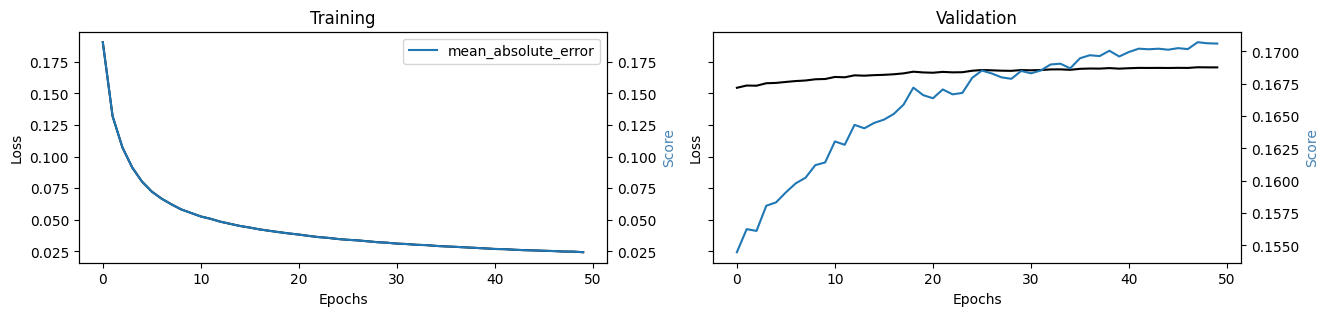

In [83]:
# train
training = model.fit(x=[X_train["user"], X_train["product"]], y=y_train, 
                     epochs=50, batch_size=128, shuffle=True, verbose=0, validation_split=0.3)
model = training.model
utils_plot_keras_training(training)

In [84]:
# test
test = X_test
test["y"] = y_test
test["yhat"] = model.predict([X_test["user"], X_test["product"]])
test

631/631 [==============================] - 1s 1ms/step


,user,product,y,yhat
67037,431,7316,0.888889,0.727008
42175,287,412,0.555556,0.573618
93850,598,3217,0.555556,0.710856
6187,41,2248,0.777778,0.588211
12229,74,1210,0.777778,0.652626
...,...,...,...,...
57416,379,3661,0.333333,0.830737
67290,433,6513,0.666667,0.640155
33423,225,4153,0.888889,0.623697
98552,606,1008,0.555556,0.805869


In [86]:
# overall
y_test = test["y"]
predicted = test["yhat"]

print("Mean Squared Error (Σ(y-pred)^2/n):", "{:,.3f}".format(metrics.mean_squared_error(y_test, predicted)))
print("Root Mean Squared Error (sqrt(Σ(y-pred)^2/n)):", "{:,.3f}".format(np.sqrt(metrics.mean_squared_error(y_test, predicted))))
print("Mean Absolute Error (Σ|y-pred|/n):", "{:,.3f}".format(metrics.mean_absolute_error(y_test, predicted)))
print("Mean Absolute Perc Error (Σ(|y-pred|/y)/n)*100%:", str(round(np.mean(np.abs((y_test-predicted)/predicted)*100), 2))+"%")

Mean Squared Error (Σ(y-pred)^2/n): 0.048
Root Mean Squared Error (sqrt(Σ(y-pred)^2/n)): 0.220
Mean Absolute Error (Σ|y-pred|/n): 0.171
Mean Absolute Perc Error (Σ(|y-pred|/y)/n)*100%: 28.14%


In [87]:
# single case
i = 10
print("--- user", i, "---")

top = 5
y_test = test[test["user"]==i].sort_values("y", ascending=False)["product"].values[:top]
print("y_test:", y_test)

predicted = test[test["user"]==i].sort_values("yhat", ascending=False)["product"].values[:top]
print("predicted:", predicted)

true_positive = len(list(set(y_test) & set(predicted)))
print("true positive:", true_positive, "("+str(round(true_positive/top*100,1))+"%)")
print("accuracy:", str(round(metrics.accuracy_score(y_test,predicted)*100,1))+"%")

--- user 10 ---
y_test: [1502  463 1398  546  615]
predicted: [ 463 1502    9 1065  837]
true positive: 2 (40.0%)
accuracy: 0.0%
